# インポート

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import os
import lightgbm as lgb

#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# pillowをインポート
from PIL import Image
from matplotlib_venn import venn2, venn2_circles

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [337]:
# %env DATA_ROOT Desktop/副業/SIGNATE/AIQuest/PBL/PBL_AI

# 各種ディレクトリの定義

In [3]:
# dataset_root = os.environ.get('DATA_ROOT', None)
# assert dataset_root is not None

# input_dir = os.path.join(dataset_root, "inputs")
# output_dir = os.path.join(dataset_root, "outputs")
# os.makedirs(output_dir, exist_ok=True)

In [311]:
# sales_history_df = pd.read_csv('./inputs/sales_history.csv')
sales_history_addfeature_df = pd.read_pickle('./inputs/sales_history_addfeature1.pickle')
# category_names_df = pd.read_csv('./inputs/category_names.csv')
# item_categories_df = pd.read_csv('./inputs/item_categories.csv')
item_categories_df = pd.read_pickle('./inputs/item_categories_addname')
item_categories_df
test_df = pd.read_csv('./inputs/test.csv')

In [6]:
df = sales_history_addfeature_df.copy()

In [ ]:
sample_submission_df = pd.read_csv('./inputs/sample_submission.csv')
sample_submission_df

店舗数 * 商品数

In [221]:
18 * 170

3060

# test_dfフォーマット

In [179]:
test_df

,index,商品ID,店舗ID
0,0,1000001,0
1,1,1000001,1
2,2,1000001,2
3,3,1000001,3
4,4,1000001,4
...,...,...,...
3055,3055,3500001,13
3056,3056,3500001,14
3057,3057,3500001,15
3058,3058,3500001,16


# 去年と同じ売り上げ個数なのでは？

## submit_df作る

In [180]:
submit_df = test_df.copy()
submit_df = submit_df.set_index('index')
submit_df['売り上げ個数'] = 0
submit_df[['店舗ID', '商品ID']] = submit_df[['店舗ID', '商品ID']].astype(str)
submit_df

,商品ID,店舗ID,売り上げ個数
index,,,
0,1000001,0,0
1,1000001,1,0
2,1000001,2,0
3,1000001,3,0
4,1000001,4,0
...,...,...,...
3055,3500001,13,0
3056,3500001,14,0
3057,3500001,15,0


今回の予測ターゲットは2019年12月における18店舗×170商品における予想売上数です

## テストデータと同じ商品IDで絞り込み

In [181]:
df_isin_test = sales_history_addfeature_df[sales_history_addfeature_df['商品ID'].isin(test_df['商品ID'].astype(str))]

In [182]:
df_isin_test.商品ID.nunique()

170

In [183]:
df_isin_test.店舗ID.nunique()

18

### 2018年12月で絞り込み

In [184]:
df_isin_test_201812 = df_isin_test[(df_isin_test['日付'] >= '2018-12-01') & (df_isin_test['日付'] <= '2018-12-31')]

In [185]:
df_isin_test_201812_sort = df_isin_test_201812.sort_values(["日付", "店舗ID", "商品ID"])

In [186]:
df_isin_test_201812_sort = df_isin_test_201812_sort.set_index('日付')
df_isin_test_201812_sort

,店舗ID,商品ID,商品価格,売上個数,商品カテゴリ,商品カテゴリ名,holiday,year_cat,month_cat,day_cat,year,month,day,weekday_cat,weekday,month_cos,month_sin,weekday_cos,weekday_sin,day_cos,day_sin,商品カテゴリ名_1,商品カテゴリ名_2
日付,,,,,,,,,,,,,,,,,,,,,,,
2018-12-01,0,1000005,250,1.0,100,映画 - DVD,0,2018,12,01,2018,12,1,土曜日,5,1.0,-2.449294e-16,0.5,-0.866025,0.97953,2.012985e-01,映画,DVD
2018-12-01,0,1200001,510,1.0,120,音楽 - その他,0,2018,12,01,2018,12,1,土曜日,5,1.0,-2.449294e-16,0.5,-0.866025,0.97953,2.012985e-01,音楽,その他
2018-12-01,0,1200031,340,1.0,120,音楽 - その他,0,2018,12,01,2018,12,1,土曜日,5,1.0,-2.449294e-16,0.5,-0.866025,0.97953,2.012985e-01,音楽,その他
2018-12-01,0,1200039,340,1.0,120,音楽 - その他,0,2018,12,01,2018,12,1,土曜日,5,1.0,-2.449294e-16,0.5,-0.866025,0.97953,2.012985e-01,音楽,その他
2018-12-01,0,1400004,340,1.0,140,映画 - ブルーレイ,0,2018,12,01,2018,12,1,土曜日,5,1.0,-2.449294e-16,0.5,-0.866025,0.97953,2.012985e-01,映画,ブルーレイ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,9,1700016,1440,2.0,170,ギフト - カード、パズル等,0,2018,12,31,2018,12,31,月曜日,0,1.0,-2.449294e-16,1.0,0.000000,1.00000,-2.449294e-16,ギフト,カード、パズル等
2018-12-31,9,1700019,1700,1.0,170,ギフト - カード、パズル等,0,2018,12,31,2018,12,31,月曜日,0,1.0,-2.449294e-16,1.0,0.000000,1.00000,-2.449294e-16,ギフト,カード、パズル等
2018-12-31,9,2400001,2550,1.0,240,ギフト - ボードゲーム,0,2018,12,31,2018,12,31,月曜日,0,1.0,-2.449294e-16,1.0,0.000000,1.00000,-2.449294e-16,ギフト,ボードゲーム


#### '商品ID', '店舗ID'の売り上げ個数の合計を計算

In [187]:
# sales_history_df_201812_group = sales_history_df_201812_sort.groupby(['商品ID', '店舗ID']).agg({"売上個数": ["sum", "mean", "median", "count", "max"]})
df_isin_test_201812_group = df_isin_test_201812_sort.groupby(['商品ID', '店舗ID']).agg({"売上個数": ["sum"]})

In [188]:
df_isin_test_201812_group = df_isin_test_201812_group.sort_values(['商品ID','店舗ID']).reset_index()

In [189]:
df_isin_test_201812_group

,商品ID,店舗ID,売上個数
,,,sum
0,1000001,10,3.0
1,1000001,11,2.0
2,1000001,12,2.0
3,1000001,13,4.0
4,1000001,16,1.0
...,...,...,...
1777,3500001,13,3.0
1778,3500001,17,1.0
1779,3500001,2,1.0


In [190]:
df_isin_test_201812_group.columns = ["".join(c) for c in df_isin_test_201812_group.columns]
df_isin_test_201812_group.columns

Index(['商品ID', '店舗ID', '売上個数sum'], dtype='object')

In [191]:
df_isin_test_201812_group = df_isin_test_201812_group.reset_index()

In [192]:
df_isin_test_201812_group

,index,商品ID,店舗ID,売上個数sum
0,0,1000001,10,3.0
1,1,1000001,11,2.0
2,2,1000001,12,2.0
3,3,1000001,13,4.0
4,4,1000001,16,1.0
...,...,...,...,...
1777,1777,3500001,13,3.0
1778,1778,3500001,17,1.0
1779,1779,3500001,2,1.0
1780,1780,3500001,3,1.0


In [193]:
df_isin_test_201812_group

,index,商品ID,店舗ID,売上個数sum
0,0,1000001,10,3.0
1,1,1000001,11,2.0
2,2,1000001,12,2.0
3,3,1000001,13,4.0
4,4,1000001,16,1.0
...,...,...,...,...
1777,1777,3500001,13,3.0
1778,1778,3500001,17,1.0
1779,1779,3500001,2,1.0
1780,1780,3500001,3,1.0


## 去年の12月同じ, 去年売れてないやつはfillna(定数)

In [194]:
df_isin_test_201812_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    1782 non-null   int64  
 1   商品ID     1782 non-null   object 
 2   店舗ID     1782 non-null   object 
 3   売上個数sum  1782 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 55.8+ KB


In [195]:
submit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3060 entries, 0 to 3059
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   商品ID    3060 non-null   object
 1   店舗ID    3060 non-null   object
 2   売り上げ個数  3060 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 95.6+ KB


In [196]:
sub = pd.merge(submit_df, df_isin_test_201812_group, on=['商品ID','店舗ID'], how='left')
sub['売上個数sum'] = sub['売上個数sum'].fillna(1.5)
sub = sub.reset_index()
sub = sub[['index', '売上個数sum']]

In [197]:
sub

,index,売上個数sum
0,NaN,1.5
1,NaN,1.5
2,NaN,1.5
3,5.0,9.0
4,6.0,7.0
...,...,...
3055,1777.0,3.0
3056,NaN,1.5
3057,NaN,1.5
3058,NaN,1.5


## 去年の12月と同じ, 去年売れてないやつはfillna(平均)

年、月、商品ID、店舗IDで集約して売り上げ個数を合計→ 商品ID、店舗IDで集約し、売り上げの平均を求める。
という手法でスコア3.7くらいでした。

### 年、月、商品ID、店舗IDで集約して売り上げ個数を合計

In [212]:
df_isin_test.商品ID.nunique()

170

In [213]:
df_group = df_isin_test.groupby(['year', 'month','商品ID', '店舗ID'])['売上個数'].agg(['sum']).reset_index()
df_group

,year,month,商品ID,店舗ID,sum
0,2018,1,1000001,0,6.0
1,2018,1,1000001,1,2.0
2,2018,1,1000001,10,12.0
3,2018,1,1000001,12,1.0
4,2018,1,1000001,13,4.0
...,...,...,...,...,...
25396,2019,10,3400003,6,4.0
25397,2019,10,3400003,9,1.0
25398,2019,10,3500001,0,1.0
25399,2019,10,3500001,13,2.0


#### 商品ID、店舗IDで集約し、売り上げの平均を求める。

In [214]:
df_group = df_group.groupby(['商品ID', '店舗ID'])['sum'].agg(['mean']).reset_index()
df_group

,商品ID,店舗ID,mean
0,1000001,0,2.307692
1,1000001,1,1.500000
2,1000001,10,2.277778
3,1000001,11,1.500000
4,1000001,12,1.416667
...,...,...,...
2920,3500001,5,1.000000
2921,3500001,6,1.428571
2922,3500001,7,1.000000
2923,3500001,8,1.250000


In [215]:
sub = pd.merge(submit_df, df_isin_test_201812_group, on=['商品ID','店舗ID'], how='left')
sub = sub[['商品ID', '店舗ID','index', '売上個数sum']]
sub

,商品ID,店舗ID,index,売上個数sum
0,1000001,0,NaN,NaN
1,1000001,1,NaN,NaN
2,1000001,2,NaN,NaN
3,1000001,3,5.0,9.0
4,1000001,4,6.0,7.0
...,...,...,...,...
3055,3500001,13,1777.0,3.0
3056,3500001,14,NaN,NaN
3057,3500001,15,NaN,NaN
3058,3500001,16,NaN,NaN


In [216]:
sub = pd.merge(sub, df_group, on=['商品ID','店舗ID'], how='left')
sub

,商品ID,店舗ID,index,売上個数sum,mean
0,1000001,0,NaN,NaN,2.307692
1,1000001,1,NaN,NaN,1.500000
2,1000001,2,NaN,NaN,1.800000
3,1000001,3,5.0,9.0,4.523810
4,1000001,4,6.0,7.0,5.428571
...,...,...,...,...,...
3055,3500001,13,1777.0,3.0,1.777778
3056,3500001,14,NaN,NaN,1.000000
3057,3500001,15,NaN,NaN,1.000000
3058,3500001,16,NaN,NaN,1.000000


In [223]:
sub['売上個数sum_addmean'] = np.where(sub['売上個数sum'].isnull(), sub['mean'], sub['売上個数sum'])
sub['売上個数sum_addmean'] = sub['売上個数sum_addmean'].fillna(1)
sub

,商品ID,店舗ID,index,売上個数sum,mean,売上個数sum_addmean
0,1000001,0,NaN,NaN,2.307692,2.307692
1,1000001,1,NaN,NaN,1.500000,1.500000
2,1000001,2,NaN,NaN,1.800000,1.800000
3,1000001,3,5.0,9.0,4.523810,9.000000
4,1000001,4,6.0,7.0,5.428571,7.000000
...,...,...,...,...,...,...
3055,3500001,13,1777.0,3.0,1.777778,3.000000
3056,3500001,14,NaN,NaN,1.000000,1.000000
3057,3500001,15,NaN,NaN,1.000000,1.000000
3058,3500001,16,NaN,NaN,1.000000,1.000000


# 2019年 → 2018/01~2019/11全部平均 fillna(定数)

In [244]:
sub = pd.merge(submit_df, df_group, on=['商品ID','店舗ID'], how='left')
sub = sub[['商品ID', '店舗ID','mean']]
sub['売上個数_予測'] = sub['mean'].fillna(0)

In [245]:
sub

,商品ID,店舗ID,mean,売上個数_予測
0,1000001,0,2.307692,2.307692
1,1000001,1,1.500000,1.500000
2,1000001,2,1.800000,1.800000
3,1000001,3,4.523810,4.523810
4,1000001,4,5.428571,5.428571
...,...,...,...,...
3055,3500001,13,1.777778,1.777778
3056,3500001,14,1.000000,1.000000
3057,3500001,15,1.000000,1.000000
3058,3500001,16,1.000000,1.000000


# 2019年 → 2018/01~2019/11全部平均 fillna(去年) → fillnaならず...  → そらそう(去年のデータで出てこないってことは一回も売れてないから)

In [254]:
sub = pd.merge(submit_df, df_group, on=['商品ID','店舗ID'], how='left')
sub = sub[['商品ID', '店舗ID','mean']]
sub

,商品ID,店舗ID,mean
0,1000001,0,2.307692
1,1000001,1,1.500000
2,1000001,2,1.800000
3,1000001,3,4.523810
4,1000001,4,5.428571
...,...,...,...
3055,3500001,13,1.777778
3056,3500001,14,1.000000
3057,3500001,15,1.000000
3058,3500001,16,1.000000


In [255]:
sub = pd.merge(sub, df_isin_test_201812_group, on=['商品ID','店舗ID'], how='left')
sub

,商品ID,店舗ID,mean,index,売上個数sum
0,1000001,0,2.307692,NaN,NaN
1,1000001,1,1.500000,NaN,NaN
2,1000001,2,1.800000,NaN,NaN
3,1000001,3,4.523810,5.0,9.0
4,1000001,4,5.428571,6.0,7.0
...,...,...,...,...,...
3055,3500001,13,1.777778,1777.0,3.0
3056,3500001,14,1.000000,NaN,NaN
3057,3500001,15,1.000000,NaN,NaN
3058,3500001,16,1.000000,NaN,NaN


In [256]:
sub['売上個数_予測'] = np.where(sub['mean'].isnull(), sub['売上個数sum'], sub['mean'])
sub

,商品ID,店舗ID,mean,index,売上個数sum,売上個数_予測
0,1000001,0,2.307692,NaN,NaN,2.307692
1,1000001,1,1.500000,NaN,NaN,1.500000
2,1000001,2,1.800000,NaN,NaN,1.800000
3,1000001,3,4.523810,5.0,9.0,4.523810
4,1000001,4,5.428571,6.0,7.0,5.428571
...,...,...,...,...,...,...
3055,3500001,13,1.777778,1777.0,3.0,1.777778
3056,3500001,14,1.000000,NaN,NaN,1.000000
3057,3500001,15,1.000000,NaN,NaN,1.000000
3058,3500001,16,1.000000,NaN,NaN,1.000000


In [257]:
sub.isnull().sum()

商品ID          0
店舗ID          0
mean        135
index      1278
売上個数sum    1278
売上個数_予測     135
dtype: int64

# (疑問)「 去年の12月のデータ」と, 「年、月、商品ID、店舗IDで集約して売り上げ個数を合計→ 商品ID、店舗IDで集約し、売り上げの平均」ってどれぐらい違う？

In [258]:
df_isin_test_201812_group

,index,商品ID,店舗ID,売上個数sum
0,0,1000001,10,3.0
1,1,1000001,11,2.0
2,2,1000001,12,2.0
3,3,1000001,13,4.0
4,4,1000001,16,1.0
...,...,...,...,...
1777,1777,3500001,13,3.0
1778,1778,3500001,17,1.0
1779,1779,3500001,2,1.0
1780,1780,3500001,3,1.0


In [259]:
df_group

,商品ID,店舗ID,mean
0,1000001,0,2.307692
1,1000001,1,1.500000
2,1000001,10,2.277778
3,1000001,11,1.500000
4,1000001,12,1.416667
...,...,...,...
2920,3500001,5,1.000000
2921,3500001,6,1.428571
2922,3500001,7,1.000000
2923,3500001,8,1.250000


In [313]:
comparison_df = pd.merge(df_group, df_isin_test_201812_group, on=['商品ID','店舗ID'], how='left')

comparison_df = comparison_df.dropna(subset=['売上個数sum'])
comparison_df['個数の誤差'] = comparison_df['売上個数sum'] - comparison_df['mean']
comparison_df = comparison_df.reset_index(drop=True)
comparison_df['index'] = comparison_df.index
comparison_df = pd.merge(comparison_df, item_categories_df, on=['商品ID'], how='left')
comparison_df

,商品ID,店舗ID,mean,index,売上個数sum,個数の誤差,商品カテゴリID,商品カテゴリ名
0,1000001,10,2.277778,0,3.0,0.722222,100,映画 - DVD
1,1000001,11,1.500000,1,2.0,0.500000,100,映画 - DVD
2,1000001,12,1.416667,2,2.0,0.583333,100,映画 - DVD
3,1000001,13,2.750000,3,4.0,1.250000,100,映画 - DVD
4,1000001,16,1.444444,4,1.0,-0.444444,100,映画 - DVD
...,...,...,...,...,...,...,...,...
1777,3500001,13,1.777778,1777,3.0,1.222222,350,本 - オーディオブック_タイプB
1778,3500001,17,1.000000,1778,1.0,0.000000,350,本 - オーディオブック_タイプB
1779,3500001,2,1.100000,1779,1.0,-0.100000,350,本 - オーディオブック_タイプB
1780,3500001,3,1.166667,1780,1.0,-0.166667,350,本 - オーディオブック_タイプB


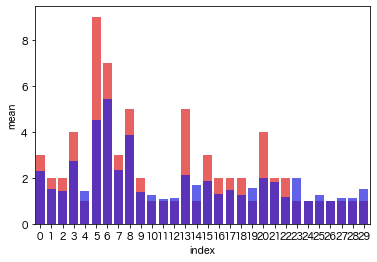

In [315]:
plt.subplot()
sns.barplot(x='index', y='売上個数sum', data=comparison_df[:30],color='red', alpha=0.7)
sns.barplot(x='index', y='mean', data=comparison_df[:30],color='blue', alpha=0.7)
plt.show()

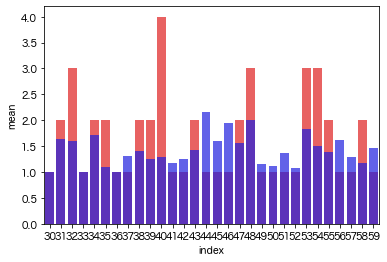

In [321]:
plt.subplot()
sns.barplot(x='index', y='売上個数sum', data=comparison_df[30:60],color='red', alpha=0.7)
sns.barplot(x='index', y='mean', data=comparison_df[30:60],color='blue', alpha=0.7)
plt.show()

<AxesSubplot:ylabel='個数の誤差'>

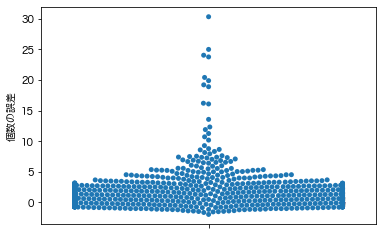

In [316]:
sns.swarmplot(data=comparison_df,  y='個数の誤差')

<AxesSubplot:ylabel='個数の誤差'>

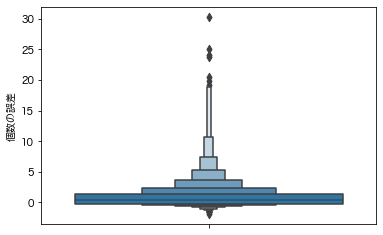

In [317]:
sns.boxenplot(data=comparison_df,y="個数の誤差")

個数の誤差が30のやつとかがある

In [320]:
print(len(comparison_df[comparison_df['個数の誤差'] > 5]))
comparison_df[comparison_df['個数の誤差'] > 5].drop(columns='index').sort_values('個数の誤差', ascending=False)

67


,商品ID,店舗ID,mean,売上個数sum,個数の誤差,商品カテゴリID,商品カテゴリ名
1652,2800001,7,14.666667,45.0,30.333333,280,ギフト - 記念品_タイプA
815,1600003,7,15.000000,40.0,25.000000,160,ギフト - 小型ゲーム
1648,2800001,3,7.950000,32.0,24.050000,280,ギフト - 記念品_タイプA
798,1600002,7,7.227273,31.0,23.772727,160,ギフト - 小型ゲーム
803,1600003,10,16.578947,37.0,20.421053,160,ギフト - 小型ゲーム
801,1600003,0,14.105263,34.0,19.894737,160,ギフト - 小型ゲーム
806,1600003,13,10.789474,30.0,19.210526,160,ギフト - 小型ゲーム
1637,2800001,0,9.095238,28.0,18.904762,280,ギフト - 記念品_タイプA
814,1600003,6,5.789474,22.0,16.210526,160,ギフト - 小型ゲーム
1059,1800003,7,5.909091,22.0,16.090909,180,ギフト - フィギュア


ギフトはやっぱり平均よりも12月の方が売れている

## まとめ

「 去年の12月のデータ」(スコア 3.78)と, 「年、月、商品ID、店舗IDで集約して売り上げ個数を合計→ 商品ID、店舗IDで集約し、売り上げの平均」(スコア 3.70)では, 「 去年の12月のデータ」の方が大きい → 去年より売れてない！

確かに, 去年の1-10月の売上個数と今年の去年の1-10月の売上個数を比べた時, 明らかに下がってた.  
「去年の12月のデータ」に下がっている率掛け算して, 下駄をはかすか？

0.7730087581405793倍下がっていた.

# → 去年の12月と同じ * 0.77, 去年売れてないやつはfillna(平均).fillna(0)

In [329]:
sub = pd.merge(submit_df, df_isin_test_201812_group, on=['商品ID','店舗ID'], how='left')
sub = sub[['商品ID', '店舗ID','index', '売上個数sum']]
sub['売上個数sum'] = sub['売上個数sum'] * 0.7730087581405793
sub

,商品ID,店舗ID,index,売上個数sum
0,1000001,0,NaN,NaN
1,1000001,1,NaN,NaN
2,1000001,2,NaN,NaN
3,1000001,3,5.0,6.957079
4,1000001,4,6.0,5.411061
...,...,...,...,...
3055,3500001,13,1777.0,2.319026
3056,3500001,14,NaN,NaN
3057,3500001,15,NaN,NaN
3058,3500001,16,NaN,NaN


In [330]:
sub = pd.merge(sub, df_group, on=['商品ID','店舗ID'], how='left')
sub

,商品ID,店舗ID,index,売上個数sum,mean
0,1000001,0,NaN,NaN,2.307692
1,1000001,1,NaN,NaN,1.500000
2,1000001,2,NaN,NaN,1.800000
3,1000001,3,5.0,6.957079,4.523810
4,1000001,4,6.0,5.411061,5.428571
...,...,...,...,...,...
3055,3500001,13,1777.0,2.319026,1.777778
3056,3500001,14,NaN,NaN,1.000000
3057,3500001,15,NaN,NaN,1.000000
3058,3500001,16,NaN,NaN,1.000000


In [331]:
sub['売上個数sum_addmean'] = np.where(sub['売上個数sum'].isnull(), sub['mean'], sub['売上個数sum'])
sub['売上個数_予測'] = sub['売上個数sum_addmean'].fillna(0)
sub

,商品ID,店舗ID,index,売上個数sum,mean,売上個数sum_addmean,売上個数_予測
0,1000001,0,NaN,NaN,2.307692,2.307692,2.307692
1,1000001,1,NaN,NaN,1.500000,1.500000,1.500000
2,1000001,2,NaN,NaN,1.800000,1.800000,1.800000
3,1000001,3,5.0,6.957079,4.523810,6.957079,6.957079
4,1000001,4,6.0,5.411061,5.428571,5.411061,5.411061
...,...,...,...,...,...,...,...
3055,3500001,13,1777.0,2.319026,1.777778,2.319026,2.319026
3056,3500001,14,NaN,NaN,1.000000,1.000000,1.000000
3057,3500001,15,NaN,NaN,1.000000,1.000000,1.000000
3058,3500001,16,NaN,NaN,1.000000,1.000000,1.000000


(スコア 3.68)

# Submit

In [332]:
sub

,商品ID,店舗ID,index,売上個数sum,mean,売上個数sum_addmean,売上個数_予測
0,1000001,0,NaN,NaN,2.307692,2.307692,2.307692
1,1000001,1,NaN,NaN,1.500000,1.500000,1.500000
2,1000001,2,NaN,NaN,1.800000,1.800000,1.800000
3,1000001,3,5.0,6.957079,4.523810,6.957079,6.957079
4,1000001,4,6.0,5.411061,5.428571,5.411061,5.411061
...,...,...,...,...,...,...,...
3055,3500001,13,1777.0,2.319026,1.777778,2.319026,2.319026
3056,3500001,14,NaN,NaN,1.000000,1.000000,1.000000
3057,3500001,15,NaN,NaN,1.000000,1.000000,1.000000
3058,3500001,16,NaN,NaN,1.000000,1.000000,1.000000


In [333]:
#submit用のCSVを作成
final_sub = pd.DataFrame({"index":sub.index, "y":sub['売上個数_予測']})
print('sub["y"].isnull().sum()=', final_sub['y'].isnull().sum())
final_sub

sub["y"].isnull().sum()= 0


,index,y
0,0,2.307692
1,1,1.500000
2,2,1.800000
3,3,6.957079
4,4,5.411061
...,...,...
3055,3055,2.319026
3056,3056,1.000000
3057,3057,1.000000
3058,3058,1.000000


In [334]:
# final_sub.to_csv('./outputs/submission7.csv', header=False, index=False)